In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline


## データの準備

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28


In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
from keras.utils import np_utils

In [7]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


## Build Monte Carlo Model and run experiments

In [57]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [58]:
model = get_model(mc=False, act="relu")
mc_model = get_model(mc=True, act="relu")


In [59]:
h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=1,
              validation_data=(x_test, y_test))


Epoch 1/10
469/469 [==============================] - 8s 15ms/step - loss: 0.2459 - accuracy: 0.9255 - val_loss: 0.0526 - val_accuracy: 0.9820
Epoch 2/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0835 - accuracy: 0.9752 - val_loss: 0.0396 - val_accuracy: 0.9866
Epoch 3/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0630 - accuracy: 0.9803 - val_loss: 0.0337 - val_accuracy: 0.9890
Epoch 4/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0517 - accuracy: 0.9842 - val_loss: 0.0360 - val_accuracy: 0.9890
Epoch 5/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0446 - accuracy: 0.9862 - val_loss: 0.0323 - val_accuracy: 0.9896
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0392 - accuracy: 0.9881 - val_loss: 0.0283 - val_accuracy: 0.9899
Epoch 7/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0288 - val_accuracy: 0.9912

In [60]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027393139898777008
Test accuracy: 0.9916999936103821


In [61]:
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 8s 15ms/step - loss: 0.2333 - accuracy: 0.9285 - val_loss: 0.1044 - val_accuracy: 0.9680
Epoch 2/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0855 - accuracy: 0.9748 - val_loss: 0.0758 - val_accuracy: 0.9777
Epoch 3/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0642 - accuracy: 0.9810 - val_loss: 0.0623 - val_accuracy: 0.9832
Epoch 4/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0516 - accuracy: 0.9838 - val_loss: 0.0597 - val_accuracy: 0.9821
Epoch 5/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0451 - accuracy: 0.9857 - val_loss: 0.0570 - val_accuracy: 0.9826
Epoch 6/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0375 - accuracy: 0.9875 - val_loss: 0.0463 - val_accuracy: 0.9865
Epoch 7/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0344 - accuracy: 0.9888 - val_loss: 0.0518 - val_accuracy: 0.9857

In [62]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)


100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


In [63]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))


MC accuracy: 98.5%


In [64]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))


MC-ensemble accuracy: 99.2%


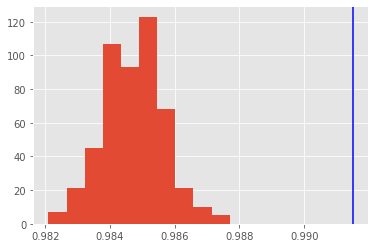

In [65]:
plt.hist(accs);
plt.axvline(x=ensemble_acc, color="b");


## Explore the Monte Carlo predictions

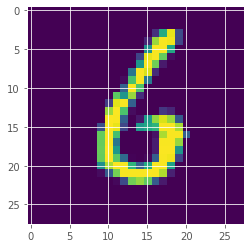

In [249]:
idx = 50
plt.imshow(x_test[idx][:,:,0])

In [39]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))


posterior mean: 4
true label: 4

class: 0; proba: 0.0%; var: 0.11% 
class: 1; proba: 1.2%; var: 5.90% 
class: 2; proba: 3.2%; var: 10.69% 
class: 3; proba: 0.0%; var: 0.07% 
class: 4; proba: 69.6%; var: 35.31% 
class: 5; proba: 0.0%; var: 0.03% 
class: 6; proba: 24.5%; var: 32.78% 
class: 7; proba: 1.3%; var: 7.53% 
class: 8; proba: 0.1%; var: 1.39% 
class: 9; proba: 0.0%; var: 0.00% 


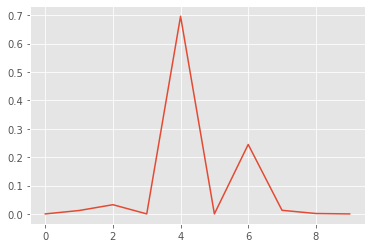

In [40]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

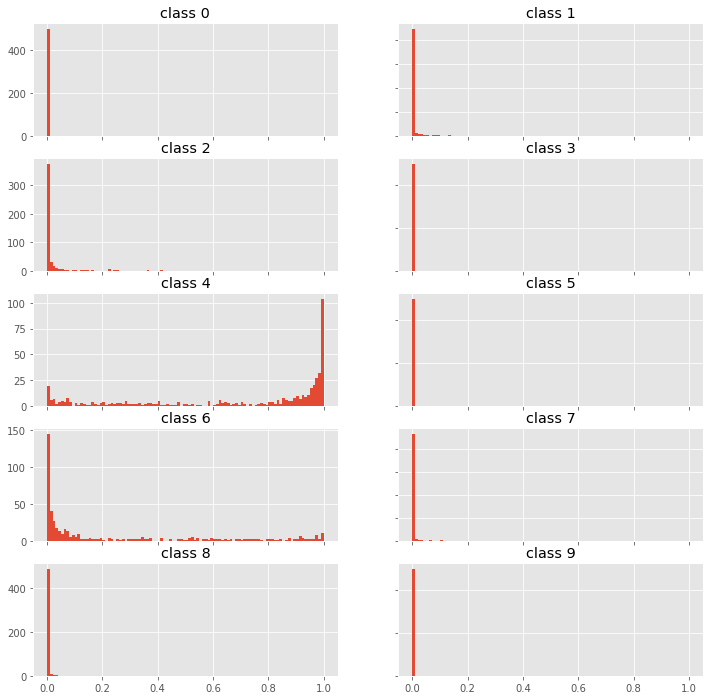

In [41]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()

## Find the most uncertain examples

### 1. Selection by probability

In [66]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [67]:
(np.array(max_means)).argsort()[:3]

array([247, 115, 320])

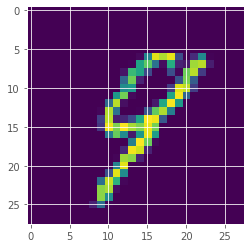

In [68]:
plt.imshow(x_test[92][:,:,0])

### 2. Selection by variance

In [24]:
max_vars = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    max_vars.append(px.std(axis=0)[px.mean(axis=0).argmax()])

In [25]:
(-np.array(max_vars)).argsort()[:10]

array([211, 247,  62, 115,  92, 326,  18, 404, 337, 119])

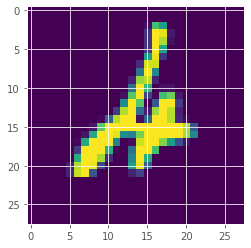

In [33]:
plt.imshow(x_test[247][:,:,0])

## How is the uncertainty measure behaved?

In [69]:
random_img = np.random.random(input_shape)

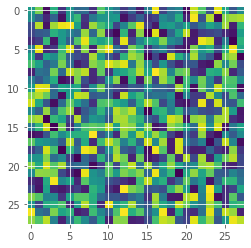

In [70]:
plt.imshow(random_img[:,:,0]);

In [71]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

100%|██████████| 500/500 [00:23<00:00, 21.28it/s]


In [72]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 8

class: 0; proba: 0.4%; var: 1.80% 
class: 1; proba: 0.1%; var: 0.65% 
class: 2; proba: 11.1%; var: 17.80% 
class: 3; proba: 5.3%; var: 11.03% 
class: 4; proba: 0.0%; var: 0.10% 
class: 5; proba: 6.8%; var: 11.49% 
class: 6; proba: 3.4%; var: 5.71% 
class: 7; proba: 0.2%; var: 1.01% 
class: 8; proba: 72.4%; var: 23.35% 
class: 9; proba: 0.3%; var: 1.13% 


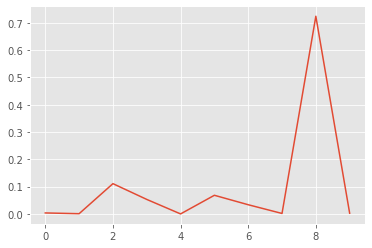

In [73]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

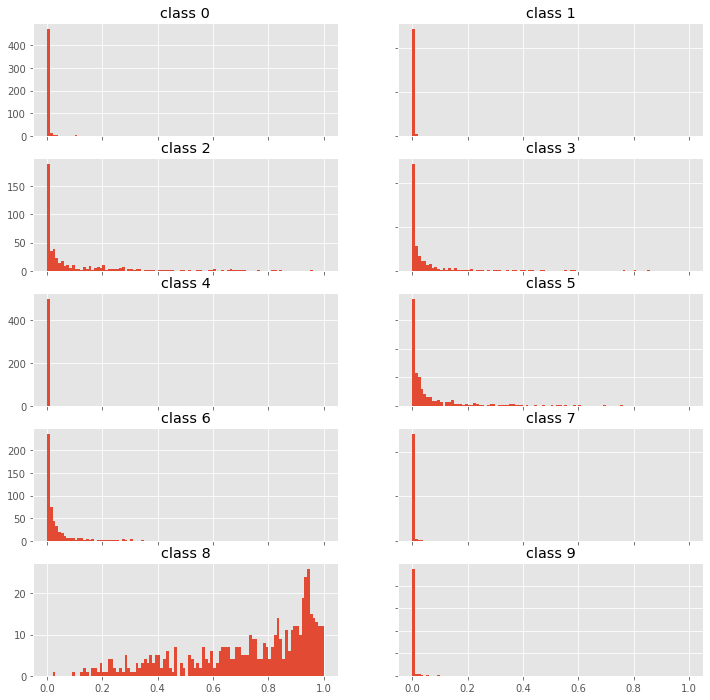

In [74]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()

## ロバスト

In [205]:
n_img = random_img + x_test[i]

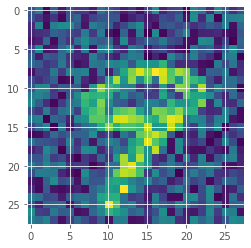

In [206]:
plt.imshow(n_img[:,:,0]);

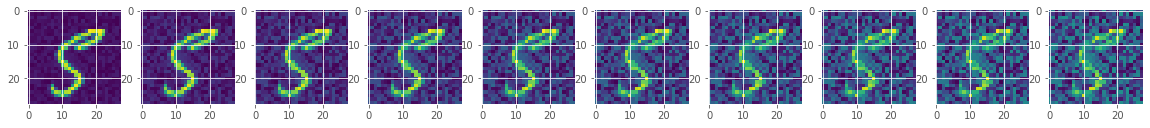

In [207]:
fig = plt.figure(figsize=(20, 10))

for i in range(1,11):
  j = i + 0
  noise_img = 0.1 * j *random_img[:,:,0] + x_test[idx][:,:,0]
  ax = fig.add_subplot(1, 10, i)
  ax.imshow(noise_img)

## ノイズ×1.0

In [140]:
noise_img1 = []

for i in range(len(x_test)):
  n_img = random_img + x_test[i]
  noise_img1.append(n_img)

In [141]:
noise_img1 = np.array(noise_img1)

In [142]:
noise_img1.shape

(10000, 28, 28, 1)

## ノーマルCNN

In [147]:
# score of the normal model
score = model.evaluate(noise_img1, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.253007411956787
Test accuracy: 0.4555000066757202


## MCドロップアウト

In [143]:
mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(noise_img1, batch_size=1000)
    mc_predictions.append(y_p)


100%|██████████| 500/500 [02:41<00:00,  3.11it/s]


In [144]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))


MC accuracy: 64.1%


In [145]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))


MC-ensemble accuracy: 69.3%


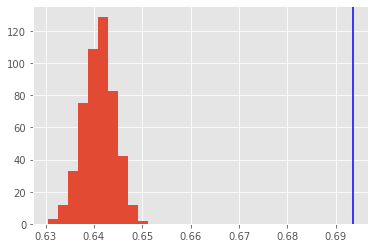

In [107]:
plt.hist(accs);
plt.axvline(x=ensemble_acc, color="b");


In [108]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [109]:
(-np.array(max_vars)).argsort()[:10]

array([211, 247,  62, 115,  92, 326,  18, 404, 337, 119])

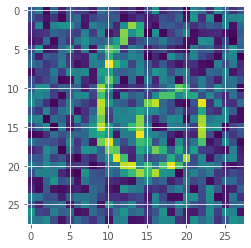

In [116]:
idx = 100
plt.imshow(noise_img[idx][:,:,0])

In [117]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))


posterior mean: 6
true label: 6

class: 0; proba: 0.3%; var: 1.36% 
class: 1; proba: 0.0%; var: 0.01% 
class: 2; proba: 0.1%; var: 0.43% 
class: 3; proba: 0.0%; var: 0.18% 
class: 4; proba: 0.0%; var: 0.12% 
class: 5; proba: 0.2%; var: 0.63% 
class: 6; proba: 85.8%; var: 25.10% 
class: 7; proba: 0.0%; var: 0.00% 
class: 8; proba: 13.7%; var: 24.80% 
class: 9; proba: 0.0%; var: 0.10% 


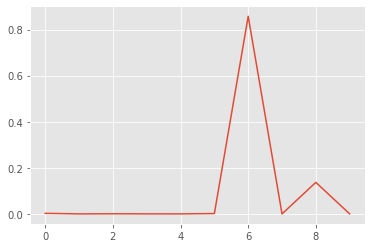

In [118]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

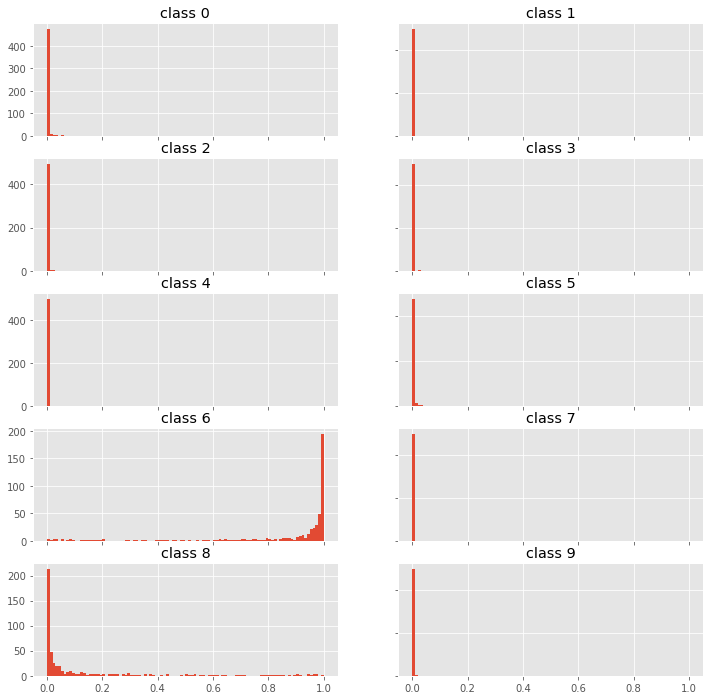

In [119]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()

## ノイズ×0.5

In [136]:
noise_img = []

for i in range(len(x_test)):
  n_img = 0.5*random_img + x_test[i]
  noise_img.append(n_img)

In [137]:
noise_img = np.array(noise_img)

In [138]:
noise_img.shape

(10000, 28, 28, 1)

## ノーマルCNN

In [139]:
# score of the normal model
score = model.evaluate(noise_img, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11934208124876022
Test accuracy: 0.9632999897003174


## MCドロップアウト

In [126]:
mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(noise_img, batch_size=1000)
    mc_predictions.append(y_p)


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


In [127]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))


MC accuracy: 94.9%


In [128]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))


MC-ensemble accuracy: 97.2%


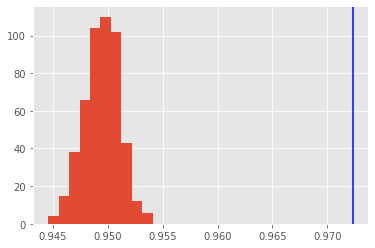

In [129]:
plt.hist(accs);
plt.axvline(x=ensemble_acc, color="b");


In [130]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [131]:
(-np.array(max_vars)).argsort()[:10]

array([211, 247,  62, 115,  92, 326,  18, 404, 337, 119])

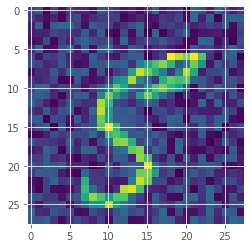

In [132]:
idx = 211
plt.imshow(noise_img[idx][:,:,0])

In [133]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))


posterior mean: 3
true label: 5

class: 0; proba: 0.1%; var: 0.67% 
class: 1; proba: 0.0%; var: 0.00% 
class: 2; proba: 0.0%; var: 0.00% 
class: 3; proba: 39.0%; var: 40.70% 
class: 4; proba: 0.0%; var: 0.00% 
class: 5; proba: 31.9%; var: 37.37% 
class: 6; proba: 0.0%; var: 0.05% 
class: 7; proba: 0.0%; var: 0.04% 
class: 8; proba: 28.7%; var: 36.43% 
class: 9; proba: 0.3%; var: 1.81% 


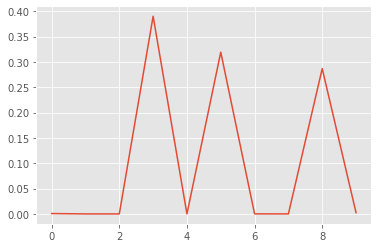

In [134]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

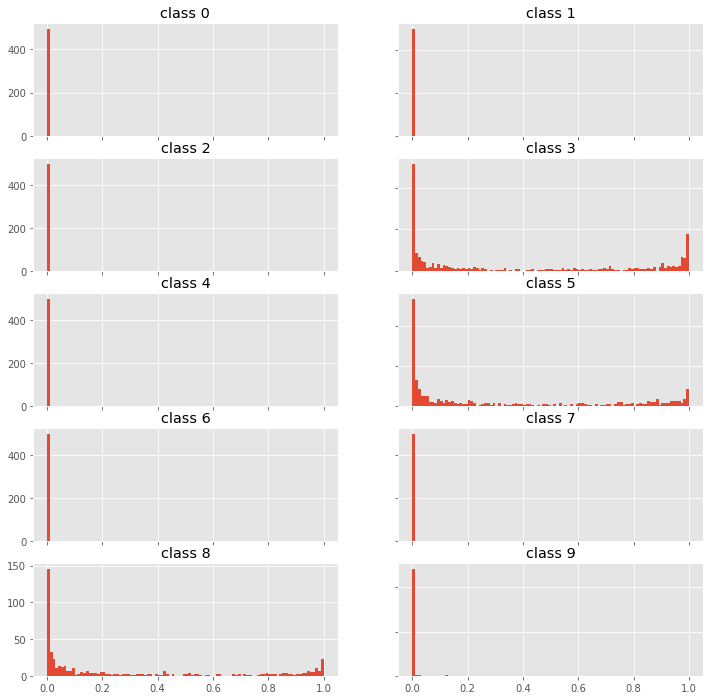

In [135]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()

# ロバスト性の比較

In [150]:
noise_imgs = []

for j in range(11):
  noi_img = []
  for i in range(len(x_test)):
    n_img = 0.1*j*random_img + x_test[i]
    noi_img.append(n_img)
  noi_img = np.array(noi_img)
  noise_imgs.append(noi_img)

In [153]:
n_pred = []

for test in noise_imgs:
  mc_predictions = []
  for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(test, batch_size=1000)
    mc_predictions.append(y_p)
  n_pred.append(mc_predictions)

100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


In [170]:
noise_accs = []
for i in n_pred:
  accs = []
  for y_p in i:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
  print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))
  noise_accs.append(accs)


MC accuracy: 98.5%
MC accuracy: 98.4%
MC accuracy: 98.2%
MC accuracy: 97.8%
MC accuracy: 96.9%
MC accuracy: 95.0%
MC accuracy: 91.6%
MC accuracy: 86.6%
MC accuracy: 80.2%
MC accuracy: 72.5%
MC accuracy: 64.1%


In [157]:
mc_pred = []

for i in n_pred:
  mc_ensemble_pred = np.array(i).mean(axis=0).argmax(axis=1)
  ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
  mc_pred.append(ensemble_acc)
  print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))


MC-ensemble accuracy: 99.1%
MC-ensemble accuracy: 99.1%
MC-ensemble accuracy: 99.0%
MC-ensemble accuracy: 98.9%
MC-ensemble accuracy: 98.4%
MC-ensemble accuracy: 97.2%
MC-ensemble accuracy: 94.5%
MC-ensemble accuracy: 90.5%
MC-ensemble accuracy: 85.3%
MC-ensemble accuracy: 78.5%
MC-ensemble accuracy: 69.1%


In [ ]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [163]:
vanila_score = []
for img in noise_imgs:
  score = model.evaluate(img, y_test, verbose=0)
  vanila_score.append(score[1])
  print('Test accuracy:', score[1])

Test accuracy: 0.9916999936103821
Test accuracy: 0.9918000102043152
Test accuracy: 0.991100013256073
Test accuracy: 0.9886999726295471
Test accuracy: 0.9811000227928162
Test accuracy: 0.9632999897003174
Test accuracy: 0.92330002784729
Test accuracy: 0.8277000188827515
Test accuracy: 0.7035999894142151
Test accuracy: 0.5831999778747559
Test accuracy: 0.4555000066757202


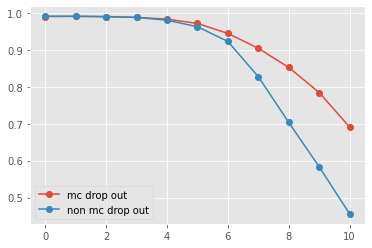

In [204]:
plt.plot(mc_pred, marker="o", label="mc drop out")
plt.plot(vanila_score, marker="o", label="non mc drop out")
plt.legend()

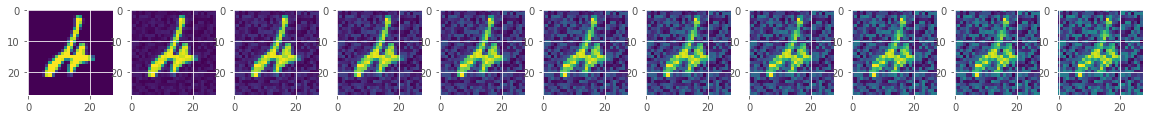

In [200]:
fig = plt.figure(figsize=(20, 10))

for i in range(11):
  ax = fig.add_subplot(1, 11, i+1)
  ax.imshow(noise_imgs[i][247][:, :, 0])

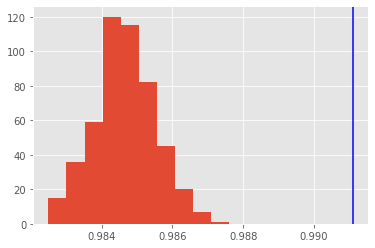

In [172]:
plt.hist(noise_accs[0])
plt.axvline(x=mc_pred[0], color="b");

In [201]:
p = []
for test in n_pred:
  p0 = np.array([p[247] for p in test])
  p.append(p0)

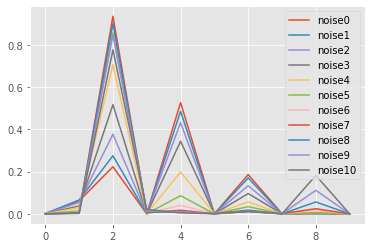

In [202]:
for i, p0 in enumerate(p):
  x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
  plt.plot(x, y, label="noise{}".format(i));
  plt.legend()

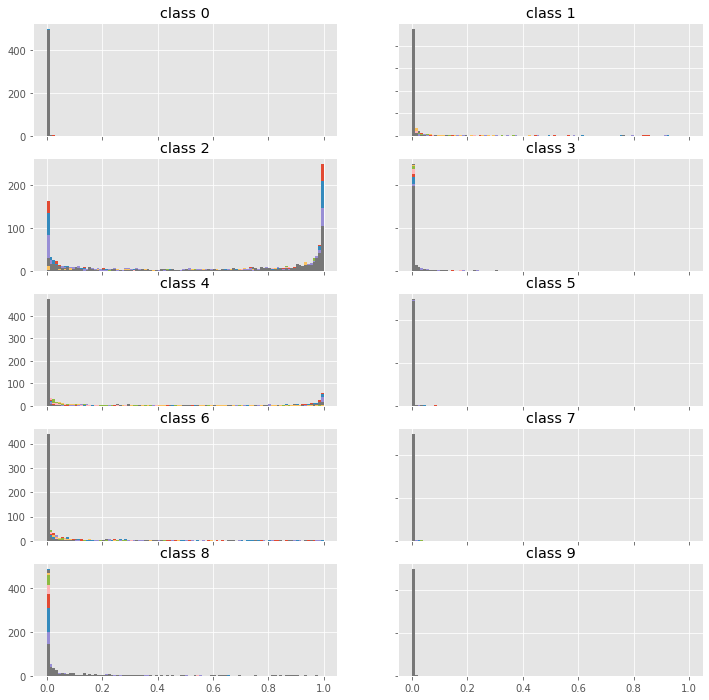

In [203]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for p0 in p:
  for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()